## Exercise 7: Nonlinear optimization, camera calibration.



These exercises will introduce you to **robust model fitting**. You will implement straight line finding using RANSAC.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from scipy.spatial.transform import Rotation
from scipy.optimize import least_squares


### RANSAC

Here you should estimate a line to a data set consisting of inliers with noise and outliers. Such data is generated by the following function:

In [87]:
def test_points(n_in, n_out):
    a = (np.random.rand(n_in)-.5)*10 #computing inliers
    b = np.vstack((a, a*.5+np.random.randn(n_in)*.25)) #computing inliers in 2D coordinates
    out=2*np.random.randn(2, n_out)
    points = np.hstack((b, out)) #adding inliers + number of outliers
    return np.random.permutation(points.T).T#permute points randomly

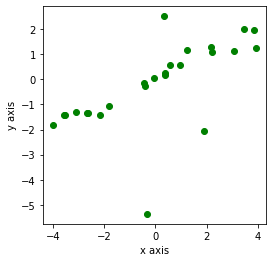

In [88]:
c= test_points(20,5)

fig = plt.figure(figsize=(4,4)) 
ax = fig.add_subplot()
    
ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.plot(c[0,:],c[1,:],'go')
plt.show()

- **Exercise 7.1**. Make a function that estimates a line, in homogeneous coordinates, given two points.


In [4]:
def estimate_line(x1,x2):
    homo_line=np.cross(x1, x2) #Ax+By+C = l = [cos(alpha) sin(alpha) -r]
    
    return homo_line

- **Exercise 7.2**. Make a function that determines if a given 2D point is an inlier or an outlier with respect to a given line. The threshold should be supplied as parameter to this function, such that it can easily be tuned later.

Recall that distance to line is given by: $|l · Π^{−1}(p)|$

In [43]:
def isinlier(x,l,thre):
    #x represents a point (should be in homogenous coordinates) and l the line. 
    #Distance to line

    d= np.abs(l@x)
    
    isinlier= d<thre
    
    #The function returns True if the point is an inlier, or False if it is an outlier. 
    return isinlier


- **Exercise 7.3**. Make a function that calculates the consensus, i.e. the number of inliers, for a line with respect to a set of points.

In [103]:
def n_inliers(points,l,thre):

    num_inliers=0
    inliers_points=[]
    for a in points:
        if (isinlier(a,l,thre) == True):
            num_inliers=num_inliers+1
            inliers_points.append(a)
        
    return num_inliers, inliers_points

- **Exercise 7.4**.Make a function that randomly draws two of n 2D points.

In [36]:
#Draw two of n points (randomly)

def draw_2points(points):
    ind=np.random.choice(range(len(points)),2)
    sel_points=points[ind,:]
    return sel_points


- **Exercise 7.5**. Assemble the functions made above to a working RANSAC algorithm for estimating lines. Set the number of iterations and the threshold manually.

In [108]:
def RANSAC_algorithm(N_iter,points,thre):
    
    #To homogeneous coordinates: 
    cnt=np.ones(len(points.T))
    points_homo=np.column_stack((points.T,cnt))

    for itera in range(N_iter):
        sel_points=draw_2points(points_homo)
        x1=sel_points[0,:]
        x2=sel_points[1,:]

        homo_line=estimate_line(x1,x2)
        num_inliers,inliers_points=n_inliers(points_homo,homo_line,thre)
        
        if itera==0:
            best_line=homo_line
            max_num_inliers=num_inliers
            best_inliers=inliers_points
        
        else:
            if num_inliers>max_num_inliers:
                max_num_inliers=num_inliers
                best_line=homo_line
                best_inliers=inliers_points
  

    return best_line,max_num_inliers,best_inliers

In [132]:
c= test_points(20,15)
best_line,max_num_inliers,best_inliers=RANSAC_algorithm(20,c,0.5)


In [135]:
print('The best line obtained was:',best_line)
print('Num_of_inliers:',max_num_inliers)

#Draw the line
m=-best_line[0]/best_line[1]
n=-best_line[2]/best_line[1]
i=np.linspace(-8, 8, num=6)
j= m*i+n

The best line obtained was: [-0.13868654  0.11856532  0.15750893]
Num_of_inliers: 31


- **Exercise 7.6**.Experiment with the algorithm, what is a good threshold for distinguishing between inliers and outliers?

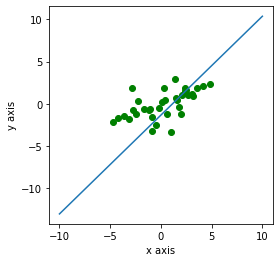

In [134]:
fig = plt.figure(figsize=(4,4)) 
ax = fig.add_subplot()
    
ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.plot(c[0,:],c[1,:],'go')
ax.plot(i,j)
plt.show()

- **Exercise 7.7**.Add the final step to your implementation, where you **fit a new line to all inliers of the best line**. The total least squares fit of a straight line to a set of points is given by the first principal component of them. Consider using the code below to get a homogeneous line along the first principal component.

In [148]:
def pca_line(x): #assumes x is a (2 x n) array of points
    d = np.cov(x)[:, 0]
    d /= np.linalg.norm(d)
    l = [d[1], -d[0]]
    l.append(-(l@x.mean(1)))
    return l

In [155]:
x=np.array(best_inliers)[:,0:2].T
line_pca=pca_line(x)

print('The new PCA line from the inliers of the best line is:')
print(line_pca)

The new PCA line from the inliers of the best line is:
[0.45356353992047177, -0.891223942258516, -0.3090253737826322]


In [156]:
#Draw the pca line
m=-line_pca[0]/line_pca[1]
n=-line_pca[2]/line_pca[1]
i2=np.linspace(-8, 8, num=6)
j2= m*i2+n

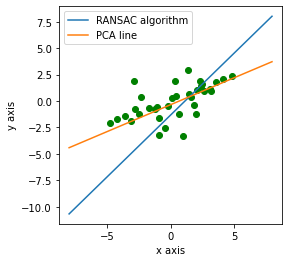

In [159]:
fig = plt.figure(figsize=(4,4)) 
ax = fig.add_subplot()
    
ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.plot(c[0,:],c[1,:],'go')
ax.plot(i,j,label='RANSAC algorithm')
ax.plot(i2,j2,label='PCA line')
plt.legend()
plt.show()

- **Exercise 7.8**.Implement the stopping criteria for RANSAC as described on the slides. Use p = 0.99.

In [168]:
s=max_num_inliers
m=len(c.T)
e= 1-(s/m)
p=0.99

N=np.log(1-p)/np.log(1-(1-e)**m)

print('The estimated upper bound on the number of iterations is:',N)

The estimated upper bound on the number of iterations is: 319.7749992365389
